<a href="https://colab.research.google.com/github/IsaacFigNewton/NoSKE-Pipeline/blob/main/NoSKE_Pipeline_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get, import dependencies

In [37]:
import spacy
import networkx as nx
import matplotlib.pyplot as plt
import json

In [2]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.7/400.7 MB 4.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Config

In [3]:
nlp = spacy.load('en_core_web_lg')
text = "The quick brown fox jumps over the lazy dog."
doc = nlp(text)

# Helpers

## Dependency KG Construction

In [38]:
def get_token_tags(t):
  tags = dict()

  # get token case
  if t.is_lower:
    tags["case"] = "lower"
  elif t.is_upper:
    tags["case"] = "upper"
  elif t.is_title:
    tags["case"] = "title"

  # get token type
  if t.is_currency:
    tags["type"] = "currency"
  elif t.like_url:
    tags["type"] = "url"
  elif t.like_email:
    tags["type"] = "email"
  elif t.is_alpha:
    tags["type"] = "word"
  elif t.like_num:
    tags["type"] = "num"
  elif t.is_space:
    tags["type"] = "whitespace"
  elif t.is_punct:
    tags["type"] = "punct"
    if t.is_left_punct:
      tags["subtype_features"] = ["left"]
    elif t.is_right_punct:
      tags["subtype_features"] = ["right"]
    if t.is_bracket:
      tags["subtype_features"].append("bracket")
    elif t.is_quote:
      tags["subtype_features"].append("quote")

  # get morphologic analysis as lists of tags
  morph_dict = t.morph.to_dict()
  morph_dict = {k: v.split(",") for k, v in morph_dict.items()}
  tags.update(morph_dict)
  return tags


def get_dep_edges(t):
  edge_list = list()
  for child in t.lefts:
    edge_list.append((
        t.i,
        child.i,
        {"type": child.dep_, "rel_pos": "after"}
    ))
  for child in t.rights:
    edge_list.append((
        t.i,
        child.i,
        {"type": child.dep_, "rel_pos": "before"}
    ))
  return edge_list


def get_dep_graph(doc):
  g = nx.DiGraph()

  # add tokens and their relations
  for t in doc:
    # define and add the token's node to G
    node_dict = {
        "text": t.text,
        "pos": t.pos_,
        "head": t.head.i,
        "lemma": t.lemma_
    }
    node_dict.update(get_token_tags(t))
    g.add_nodes_from([(t.i, node_dict)])

    # add token NER relations
    if t.ent_type_:
      g.add_nodes_from([
        (t.ent_type_, {"text": t.ent_type_})
      ])
      g.add_edges_from([
          (t.i, t.ent_type_, {"type":"type"}),
      ])
    # add dependency relations
    g.add_edges_from(get_dep_edges(t))

  return g

## Visualization

In [35]:
def kg_to_json(g):
  nodes = json.dumps(list(G.nodes(data=True)), indent=2)
  edges = json.dumps(list(G.edges(data=True)), indent=2)
  return nodes, edges

In [29]:
def plot_kg(g):
  # Extract node labels and edge labels
  node_labels = {node: G.nodes[node]['text'] for node in G.nodes() if 'text' in G.nodes[node]}
  edge_labels = {(u, v): d['type'] for u, v, d in G.edges(data=True)}

  # Position nodes using spring layout
  pos = nx.spring_layout(G, k=50)

  # Draw the graph
  plt.figure(figsize=(12, 8))
  nx.draw(
      G,
      pos,
      with_labels=True,
      labels=node_labels,
      node_size=1500,
      node_color="skyblue",
      alpha=0.8,
      linewidths=2,
      edge_color="gray"
  )
  nx.draw_networkx_edge_labels(
      G,
      pos,
      edge_labels=edge_labels,
      font_color='red'
  )
  plt.title("Semantic Knowledge Graph")
  plt.axis("off")
  plt.show()

# Construct a dependency KG from the SpaCy token info
See [RDF schema spec docs](https://www.w3.org/TR/rdf-schema/) for edge relation guidance

In [39]:
G = get_dep_graph(doc)

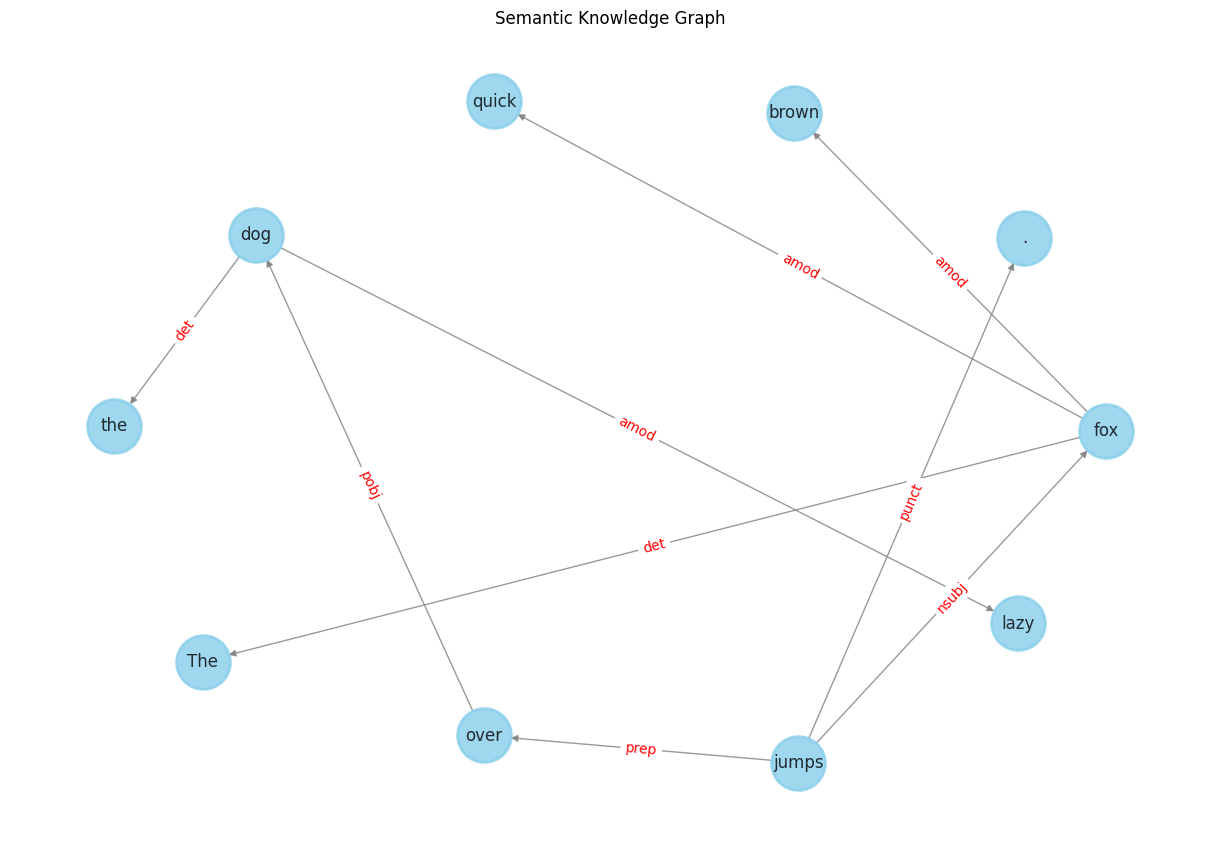

In [40]:
plot_kg(G)

In [41]:
nodes, edges = kg_to_json(G)
print("Nodes")
print(nodes)
print()
print("Edges")
print(edges)

Nodes
[
  [
    0,
    {
      "text": "The",
      "pos": "DET",
      "head": 3,
      "lemma": "the",
      "case": "title",
      "type": "word",
      "Definite": [
        "Def"
      ],
      "PronType": [
        "Art"
      ]
    }
  ],
  [
    1,
    {
      "text": "quick",
      "pos": "ADJ",
      "head": 3,
      "lemma": "quick",
      "case": "lower",
      "type": "word",
      "Degree": [
        "Pos"
      ]
    }
  ],
  [
    2,
    {
      "text": "brown",
      "pos": "ADJ",
      "head": 3,
      "lemma": "brown",
      "case": "lower",
      "type": "word",
      "Degree": [
        "Pos"
      ]
    }
  ],
  [
    3,
    {
      "text": "fox",
      "pos": "PROPN",
      "head": 4,
      "lemma": "fox",
      "case": "lower",
      "type": "word",
      "Number": [
        "Sing"
      ]
    }
  ],
  [
    4,
    {
      "text": "jumps",
      "pos": "VERB",
      "head": 4,
      "lemma": "jump",
      "case": "lower",
      "type": "word",
      "Number": [


# Get implied relations from phrase/clause-level structures